# Exercise 3

**Authors** : Helena Liz & Fernando Freire
_______________________________________________________________________________________________________________
## Scale-free networks and networks attacks

In [1]:
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import colors
%matplotlib inline
import numpy as np

## Scale-free networks.

Generate a scale-free network with $10000$ edges and add $10$ nodes in each
step (use the method *barabasi_albert_ graph(n, m)*). 

Calculate the values of $L$, $C$ and the degree distribution of the nodes. 

Generate a random network that has the same number of nodes and branches as the network that you have created.

Calculate your values of $L$, $C$ and the degree distribution of the nodes and compare the values
obtained.

### L & C

In [2]:
def get_graph_metrics1(graph):
    """
    Obtain: 
        - The clustering index (C)
        - Average shortest path length (L)
        - Order of the largest connected component (O)
    """
    largest_cc = max(nx.connected_components(graph), key=len)   
    largest_connected_subgraph = graph.subgraph(largest_cc)
    if not nx.is_connected(graph): 
        subgraph = largest_connected_subgraph
    else:
        subgraph = graph
    return nx.average_clustering(graph),\
           nx.average_shortest_path_length(subgraph),\
           largest_connected_subgraph.order()
    
def l_c_random(n_graph, n, p):
    """
    Obtain the same parameters than the previous one for different random graphs
    """
    acum_c = 0
    acum_l = 0
    acum_o = 0
    for i in range(0, n_graph):
        graph = nx.gnp_random_graph(n, p)
        c, l, o = get_graph_metrics(graph)
        acum_c += c
        acum_l += l
        acum_o += o
    return [acum_c/n_graph, acum_l/n_graph, acum_o/n_graph]

def graph_metric(metric, graph):
    """
    Promediate a node metric to all the nodes of the graph
    """
    method = getattr(nx, metric)
    return sum(method(graph).values())/graph.order()

def max_kcore_k(graph):
    """
    maximal subgraph that contains nodes of degree k or more
    """
    core_number = nx.core_number(graph)
    max_kcore = 0
    for node in core_number:
        if core_number[node] > max_kcore:
            max_kcore = core_number[node]
    return max_kcore  

def get_graph_metrics2(graph):
    """
    Obtain: 
        - Degree centrality
        - Closeness centrality
        - Betweenness centrality
        - Graph clique number
        - Average clustering
        - Max k-core k',
        - Average shortest path length'
    """
    largest_cc = max(nx.connected_components(graph), key=len)   
    largest_connected_subgraph = graph.subgraph(largest_cc)
    return [graph_metric("degree_centrality", graph),
           graph_metric("closeness_centrality", graph),
           graph_metric("betweenness_centrality", graph), 
           nx.graph_clique_number(graph),
           nx.average_clustering(graph),
           max_kcore_k(graph),
           nx.average_shortest_path_length(largest_connected_subgraph)]

In [7]:
order = 10000
edges = 10
graph_free_scale_barabasi = nx.barabasi_albert_graph(order, edges)
c, l, o = get_graph_metrics1(graph_free_scale_barabasi)

In [155]:
print("The clustering index (C) is: ", c)
print("Average shortest path length (L) is: ", l)
print("Order of the largest connected component (O): ", o)

# Result : 0.011121720734477772 3.0628272427242726 10000

The clustering index (C) is:  0.01135564000874577
Average shortest path length (L) is:  3.0595018501850184
Order of the largest connected component (O):  10000


In [14]:
print("Free scale graph size:", graph_free_scale_barabasi.size())
graph_random = nx.gnm_random_graph(order, graph_free_scale_barabasi.size())
c_random, l_random, o_random = get_graph_metrics1(graph_random)

d = {'Free Scale': [c, l], 'Random': [c_random, l_random]}
df = pd.DataFrame(data=d, index = ['Average clustering',
                                   'Average shortest path length'])
df

Free scale graph size: 99900


,Free Scale,Random
Average clustering,0.011356,0.002025
Average shortest path length,3.059502,3.403183


### Node degree distribution


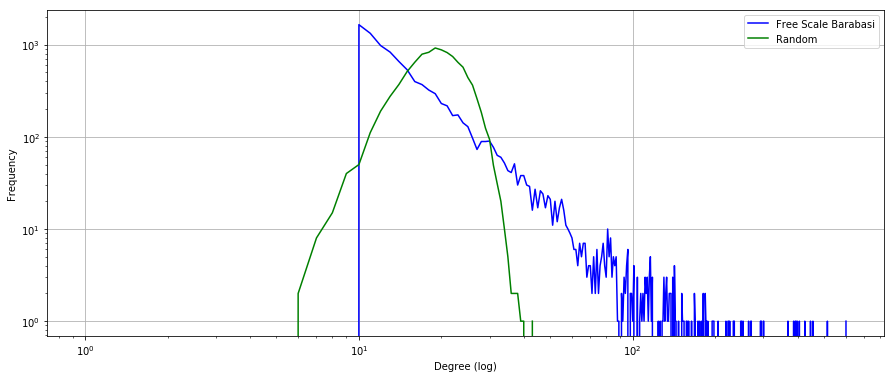

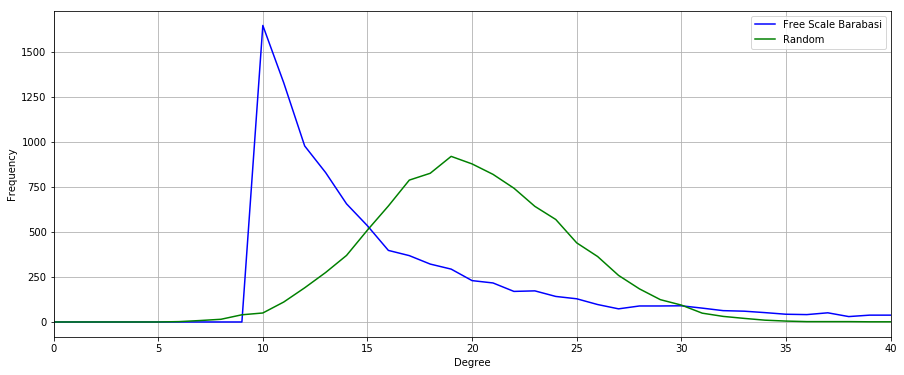

In [15]:
plt.figure(figsize=(15, 6))
plt.xlabel('Degree (log)')
plt.ylabel('Frequency')

his = nx.degree_histogram(graph_free_scale_barabasi)
plt.plot(his, color="blue")
his_al = nx.degree_histogram(graph_random)
plt.grid()
plt.plot(his_al, color='green')
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
legend_handles = [ mlines.Line2D([], [], color='blue', \
                          markersize=15, label='Free Scale Barabasi'), \
                mlines.Line2D([], [], color='green', \
                          markersize=15, label='Random')]
plt.legend(handles=legend_handles, loc = 1);

plt.figure(figsize=(15, 6))
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xlim(0, 40)
his = nx.degree_histogram(graph_free_scale_barabasi)
plt.plot(his, color="blue")
his_al = nx.degree_histogram(graph_random)
plt.grid()
plt.plot(his_al, color='green')
#plt.xscale("log", nonposx='clip')
#plt.yscale("log", nonposy='clip')
legend_handles = [ mlines.Line2D([], [], color='blue', \
                          markersize=15, label='Free Scale Barabasi'), \
                mlines.Line2D([], [], color='green', \
                          markersize=15, label='Random')]
plt.legend(handles=legend_handles, loc = 1);

### Results Comparison

It's very apparent the graph of free scale distribution with the linear decreasing region. 

The random network present the expected poisson shape.

L from free scale is similar to random network and C much larger than random network, as expected

## Network Attack.

### Random attack

Implement a routine program random_attack $(G, m)$ in Python that perform a random attack on $m$ nodes of graph $G$.

Use the previous routine to calculate the size of the largest connected component in random, small world and scale-free graphs of $1000$ nodes and $4000$ branches after attacks of 10%, 30%, 50%, 70% and 90% of the nodes of the graph.

#### Methods

In [149]:
import random

def max_subgraph(graph):
    
    all_subgraphs = nx.connected_component_subgraphs(graph)
    max_subg = None
    max_order = 0
    
    for subg in all_subgraphs:
        order = subg.order()
        if order > max_order:
            max_order = order
            max_subg = subg
            
    return max_subg

def max_subgraph_alter(graph):
    
    largest_cc = max(nx.connected_components(graph), key=len) 
    largest_connected_subgraph = graph.subgraph(largest_cc)
            
    return largest_connected_subgraph

def random_attack(graph, m, verbose=False):
    """
    remove nodes of a graph
    """
    for remove in range(0,m):
        node = random.choice(list(graph.nodes))
        if verbose: print("Removing node %s with degree %s" % (node, graph.degree(node)))
        graph.remove_node(node)

    return graph

def random_attack_percent(graph, total_nodes, percent_nodes_attacked, verbose=False):
    """
    calculate the number of nodes that we have to remove and remove them
    """
    m = total_nodes * percent_nodes_attacked / 100
    return random_attack(graph, round(m), verbose)

def node_attack(graph, percents_nodes_attacked, attack_method_name):
    """
    Attack initial_graph by removing list of percents_nodes_attacked taken into account the nodes
    previously removed.
    The initial graph is modified.
    
    Returns:
        list of int: sizes of max connected subgraph for each percent
    """
    sizes_max_connected_subgraph = []
    orders_max_connected_subgraph = []
    total_nodes = graph.order()
    percent_prev = 0
    for percent_nodes_attacked in percents_nodes_attacked:
        #print("Attacking %s nodes" % (percent_nodes_attacked))
        percent_current = percent_nodes_attacked - percent_prev
        percent_prev = percent_nodes_attacked
        #print(percent_current, percent_nodes_attacked)
        if percent_current == 0:
            attacked_graph = graph
        else:
            attacked_graph = globals()[attack_method_name](graph, total_nodes, percent_current)
        #print("Percent", percent_nodes_attacked, "Order", attacked_graph.order())
        largest_connected_subgraph = max_subgraph(attacked_graph)
        sizes_max_connected_subgraph.append(largest_connected_subgraph.size())
        orders_max_connected_subgraph.append(largest_connected_subgraph.order())
        graph = attacked_graph
    return sizes_max_connected_subgraph, orders_max_connected_subgraph

def do_attacks(percents_nodes_attacked, nodes, edges,
               attack_method_name, seed=0):
    """
    Apply the function attack_method_name for different types of graph
    """
    random.seed = seed
    n = nodes
    e = edges
    random.seed = 0
    # Create the different graphs: random, small world and scale free
    graph_random = nx.gnm_random_graph(n, e, seed=seed)
    k = int(e*2/n)
    p = 0.02
    graph_small_world = nx.watts_strogatz_graph(n, k, p, seed=seed)
    k = int(e/n)
    graph_scale_free = nx.barabasi_albert_graph(n, k, seed=seed)

    random_size, random_order = node_attack(graph_random.copy(), percents_nodes_attacked, attack_method_name)
    small_world_size, small_world_order = node_attack(graph_small_world.copy(), percents_nodes_attacked, attack_method_name)
    free_scale_size, free_scale_order = node_attack(graph_scale_free.copy(), percents_nodes_attacked, attack_method_name)
    d_sizes = {'Random': random_size, 'Small-World': small_world_size, 'Scale-Free': free_scale_size}
    df_sizes = pd.DataFrame(data=d_sizes, index = [str(i)+'%' for i in percents_nodes_attacked])
    print("Sizes of largest connected components vs %nodes removed")
    display(df_sizes)
    
    print("Orders of largest connected components vs %nodes removed")
    d_orders = {'Random': random_order, 'Small-World': small_world_order, 'Scale-Free': free_scale_order}
    df_orders = pd.DataFrame(data=d_orders, index = [str(i)+'%' for i in percents_nodes_attacked])
    display(df_orders)
    
    return graph_random, graph_small_world, graph_scale_free, df_sizes, df_orders

def plot_networks(metrics_df, attack_df, percents_nodes_attacked):
    """
    Plot networks data
    """
    x = ['Random', "Small World", "Scale Free"]
    data = metrics_df.values.tolist()

    degree_centrality = data[0]
    closeness_centrality = data[1]
    betweenness_centrality = data[2]
    graph_clique_number = data[3]
    average_clustering = data[4]
    max_kcore = data[5]
    average_shortest_path_length = data[6]

    # Last plot
    random_plot = attack_df["Random"]
    small_world_plot = attack_df["Small-World"]
    scale_free_plot = attack_df['Scale-Free']

    fig, axs = plt.subplots(2, 4, figsize=(20, 12))
    axs[0, 0].bar(x, degree_centrality, color = ["m", "c", "b"])
    axs[0, 0].set(title='degree_centrality')

    axs[0, 1].bar(x, closeness_centrality, color = ["m", "c", "b"])
    axs[0, 1].set(title='closeness_centrality')

    axs[0, 2].bar(x, betweenness_centrality, color = ["m", "c", "b"])
    axs[0, 2].set(title='betweenness_centrality')

    axs[0, 3].bar(x, graph_clique_number, color = ["m", "c", "b"])
    axs[0, 3].set(title='graph_clique_number')

    axs[1, 0].bar(x, average_clustering, color = ["m", "c", "b"])
    axs[1, 0].set(title='average_clustering')

    axs[1, 1].bar(x, max_kcore, color = ["m", "c", "b"])
    axs[1, 1].set(title='max_kcore')

    axs[1, 2].bar(x, average_shortest_path_length, color = ["m", "c", "b"])
    axs[1, 2].set(title='average_shortest_path_length')

    axs[1, 3].plot(percents_nodes_attacked, random_plot, label= "Random", color = "m")
    axs[1, 3].plot(percents_nodes_attacked, small_world_plot, label= "Small World", color = "c")
    axs[1, 3].plot(percents_nodes_attacked, scale_free_plot, label= "Scale Free", color = "b")
    plt.grid()
    plt.show()
    
def plot_attack(attack_df, percents_nodes_attacked, metric, title, x0=0, x1=100, y0=0, y1=4000):
    """
    Plot shrink of largest connected component
    """
    # Plot results
    random_plot = attack_df["Random"]
    small_world_plot = attack_df["Small-World"]
    scale_free_plot = attack_df['Scale-Free']

    plt.figure(figsize=(15, 10))
    plt.plot(percents_nodes_attacked, random_plot, label='random', color = "m")
    plt.plot(percents_nodes_attacked, small_world_plot, label='small world', color = "c")
    plt.plot(percents_nodes_attacked, scale_free_plot, label='scale free', color = "b")

    plt.xlabel('% removed nodes')
    plt.ylabel(metric + ' of largest connected component')
    plt.xlim(x0,x1)
    plt.ylim(y0,y1)
    plt.title(title)
    plt.grid()
    plt.legend()

    plt.show()
    
def plot_attack_combined(attack_random_df, attack_degree_df, percents_nodes_attacked, metric, title, x0=0, x1=100, y0=0, y1=4000):
    """
    Plot shrink of largest connected component
    """
    # Plot results
    random_plot_r = attack_random_df["Random"]
    small_world_plot_r = attack_random_df["Small-World"]
    scale_free_plot_r = attack_random_df['Scale-Free']
    
    random_plot_d = attack_degree_df["Random"]
    small_world_plot_d = attack_degree_df["Small-World"]
    scale_free_plot_d = attack_degree_df['Scale-Free']

    plt.figure(figsize=(15, 10))
    plt.plot(percents_nodes_attacked, random_plot_r, marker="o", label='Random (random attack)')
    plt.plot(percents_nodes_attacked, small_world_plot_r, marker="o", label='Small World (random attack)')
    plt.plot(percents_nodes_attacked, scale_free_plot_r, marker="o", label='Scale Free (random attack)')
    plt.plot(percents_nodes_attacked, random_plot_d, marker="x", label='Random (degree attack)')
    plt.plot(percents_nodes_attacked, small_world_plot_d, marker="x", label='Small World (degree attack)')
    plt.plot(percents_nodes_attacked, scale_free_plot_d, marker="x", label='Scale Free (degree attack)')

    plt.xlabel('% removed nodes')
    plt.ylabel(metric + ' of largest connected component')
    plt.xlim(x0,x1)
    plt.ylim(y0,y1)
    plt.title(title)
    plt.grid()
    plt.legend()

    plt.show()

#### Verification

We verify the algorithm over a random graph:

Removing node 0 with degree 5
Removing node 41 with degree 3
Removing node 95 with degree 2
Removing node 35 with degree 6
Removing node 99 with degree 1
Removing node 70 with degree 6
Removing node 28 with degree 5
Removing node 16 with degree 3
Removing node 27 with degree 3
Removing node 73 with degree 3
Removing node 30 with degree 3
Removing node 68 with degree 3
Removing node 40 with degree 4
Removing node 8 with degree 3
Removing node 50 with degree 4
Removing node 4 with degree 5
Removing node 52 with degree 1
Removing node 39 with degree 4
Removing node 87 with degree 3
Removing node 82 with degree 4
Removing node 24 with degree 5
Removing node 49 with degree 2
Removing node 79 with degree 2
Removing node 61 with degree 3
Removing node 64 with degree 1
Removing node 45 with degree 6
Removing node 1 with degree 4
Removing node 38 with degree 0
Removing node 66 with degree 2
Removing node 55 with degree 2
Removing node 7 with degree 5
Removing node 33 with degree 3
Removing node

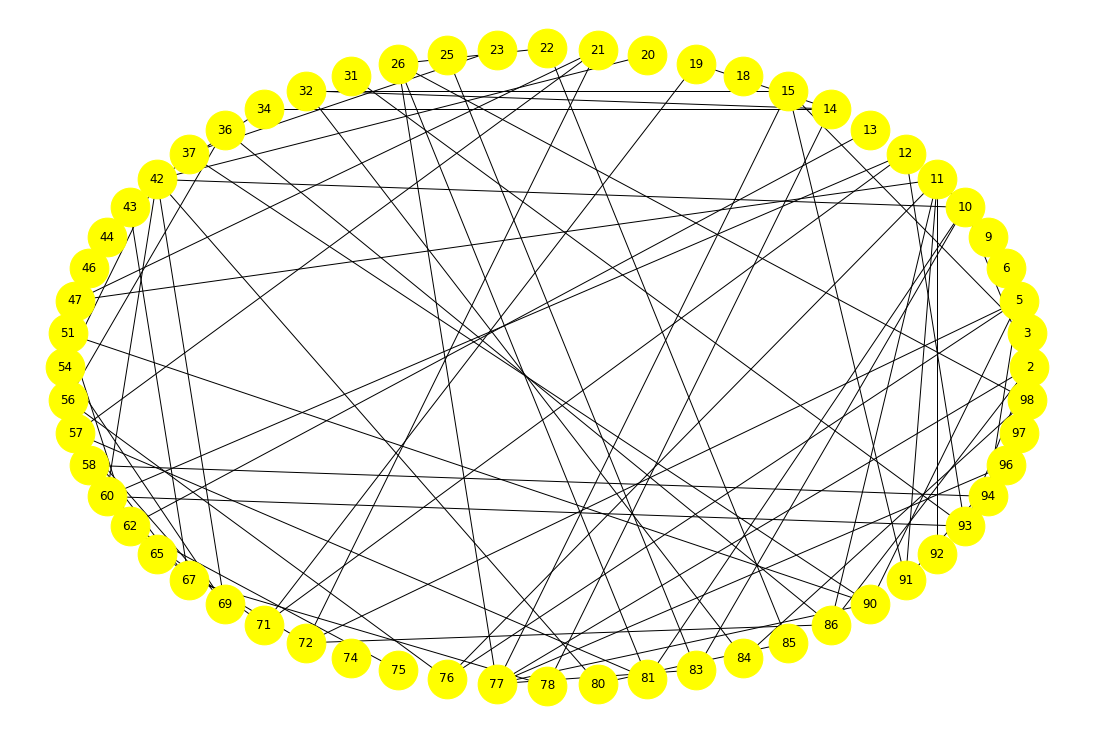

In [147]:
n = 100
e = 200
random.seed = 0
percent_nodes_attacked = 40
graph = nx.gnm_random_graph(n, e , seed = 0)
graph_attacked = random_attack_percent(graph, graph.order(), percent_nodes_attacked, verbose=True)
plt.figure(figsize=(15, 10))
nx.draw_circular(graph_attacked, with_labels = True, node_color = "yellow", node_size = 1500)

assert graph.order() == n - percent_nodes_attacked, "Graph order incorrect given the number of removed nodes"

#### Calculate sizes of the largest connected component

In [141]:
# Print the result of previous function in a table
percents_nodes_attacked = [0, 10, 30, 40, 50, 60, 70, 80, 90]
nodes = 1000
edges = 4000
graph_random, graph_small_world, graph_scale_free, attack_df_random_sizes, attack_df_random_orders =\
    do_attacks(percents_nodes_attacked, nodes, edges, 
               attack_method_name='random_attack_percent', seed=0)

Sizes of largest connected components vs %nodes removed


,Random,Small-World,Scale-Free
0%,4000,4000,3984
10%,3224,3247,3113
30%,1958,1979,1859
40%,1466,1440,1421
50%,1024,843,989
60%,669,275,684
70%,373,88,395
80%,134,18,191
90%,9,7,58


Orders of largest connected components vs %nodes removed


,Random,Small-World,Scale-Free
0%,1000,1000,1000
10%,900,900,900
30%,698,700,696
40%,595,587,588
50%,495,395,480
60%,389,142,377
70%,274,55,265
80%,130,13,144
90%,10,7,49


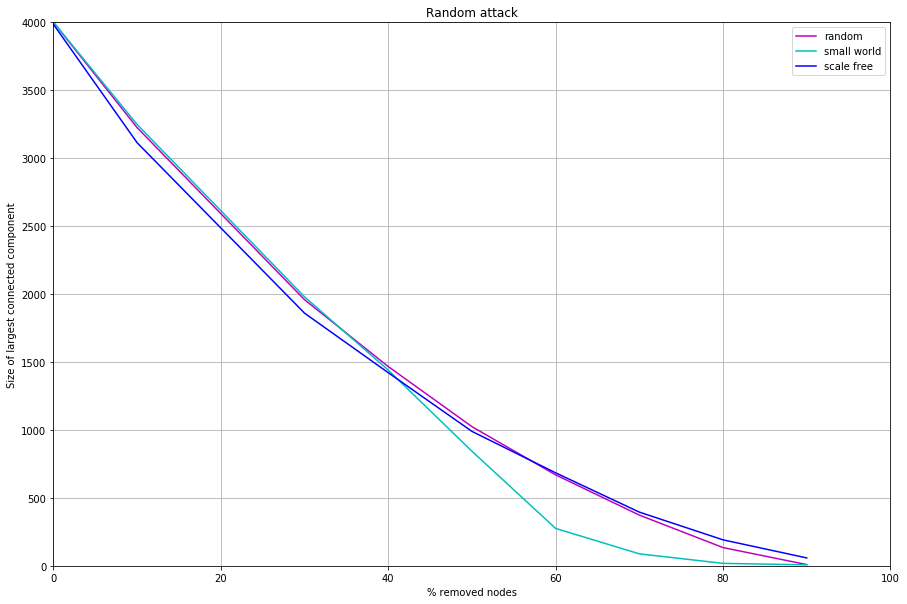

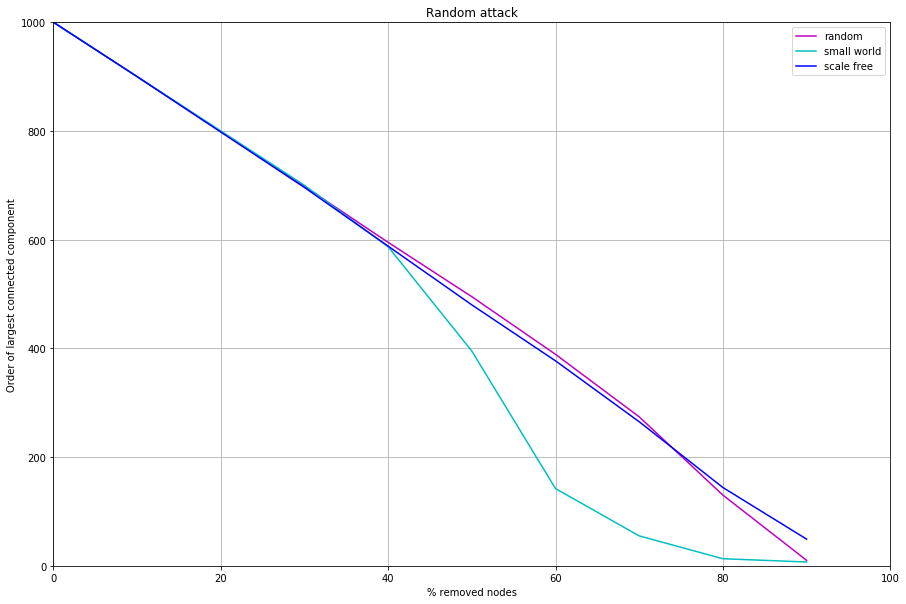

In [150]:
plot_attack(attack_df_random_sizes, percents_nodes_attacked, "Size", "Random attack")
plot_attack(attack_df_random_orders, percents_nodes_attacked, "Order", "Random attack", 0, 100, 0, 1000)

#### Graphs metrics
We calculate the metrics of all the graphs involved in order to verify that are the type of graphs expected and there are not errors.

In [142]:
# Print the output of function "get_graph_metrics2"
d = {'Random': get_graph_metrics2(graph_random), 
     'Small-World': get_graph_metrics2(graph_small_world),
     'Scale-Free': get_graph_metrics2(graph_scale_free)}
df = pd.DataFrame(data=d, index = ['Degree centrality', 'Closeness centrality',
                                  'Betweenness centrality', 'Graph clique number',
                                  'Average clustering', 'Max k-core k',
                                  'Average shortest path length'])
display(df)

,Random,Small-World,Scale-Free
Degree centrality,0.008008,0.008008,0.007976
Closeness centrality,0.282338,0.123876,0.318568
Betweenness centrality,0.002557,0.007179,0.002166
Graph clique number,3.000000,5.000000,4.000000
Average clustering,0.010371,0.601977,0.037346
Max k-core k,5.000000,6.000000,4.000000
Average shortest path length,3.552160,8.164925,3.161854


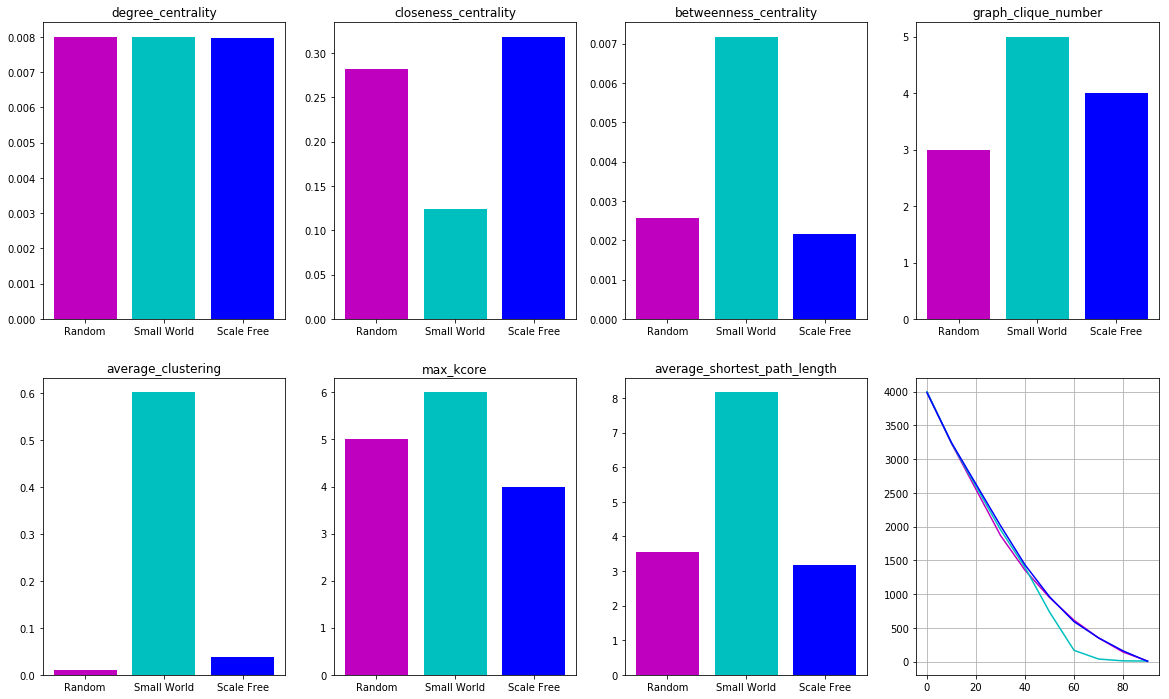

In [130]:
plot_networks(df, attack_df_random_sizes, percents_nodes_attacked)

### Degree attack

Implement a method *degree_attack(G, m)* in Python that performs an attack based on degrees to $m$ nodes of graph $G$.

Use the previous routine to calculate the size of the largest connected component in random, small world and scale-free graphs of $1000$ nodes and $4000$ branches after attacks of 10%, 30%, 50%, 70% and 90% of the nodes.

#### Methods

In [95]:
def degree_attack(graph, m, verbose=False):
    """
    Removes 'm' nodes in 'graph' in degree descending order
    """
    degree_dist_sorted = sorted([(b,a) for (a,b) in graph.degree()])
    pos = -1
    for remove in range(0,m):
        (degree, node) = degree_dist_sorted[pos]
        if verbose: print("Removing node %s with degree %s" % (node, degree))
        graph.remove_node(node)
        pos -= 1

    return graph

def degree_attack_percent(graph, total_nodes, percent_nodes_attacked, verbose=False):
    """
    Removes 'percent_nodes_attacked' in 'graph'
    """
    m = total_nodes * percent_nodes_attacked / 100
    return degree_attack(graph, round(m), verbose)

#### Verification

We verify the algorithm over a random graph: the nodes are removed by their degree, first the ones with the highest degree.

Removing node 29 with degree 8
Removing node 17 with degree 8
Removing node 25 with degree 7
Removing node 10 with degree 7
Removing node 26 with degree 6
Removing node 9 with degree 6
Removing node 28 with degree 5
Removing node 27 with degree 5
Removing node 19 with degree 5
Removing node 15 with degree 5
Removing node 2 with degree 5
Removing node 22 with degree 4
Removing node 18 with degree 4
Removing node 12 with degree 4
Removing node 6 with degree 4
Removing node 4 with degree 4
Removing node 3 with degree 4
Removing node 16 with degree 3


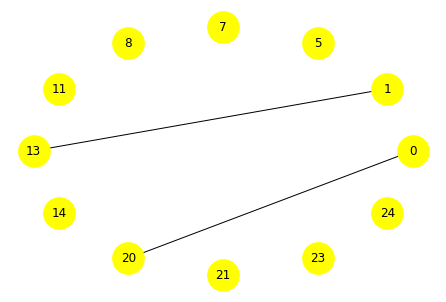

In [97]:
n = 30
e = 60
random.seed = 0
percent_nodes_attacked = 60
graph = nx.gnm_random_graph(n, e , seed = 0)
graph_attacked = degree_attack_percent(graph, graph.order(), percent_nodes_attacked, verbose=True)
nx.draw_circular(graph_attacked, with_labels = True, node_color = "yellow", node_size = 1000)

#### Calculate sizes of the largest connected component

In [143]:
percents_nodes_attacked = [0, 10, 30, 40, 50, 60, 70, 80, 90]
nodes = 1000
edges = 4000
graph_random, graph_small_world, graph_scale_free, attack_df_degree_sizes, attack_df_degree_orders  =\
    do_attacks(percents_nodes_attacked, nodes, edges, 
               attack_method_name='degree_attack_percent', seed=0)

Sizes of largest connected components vs %nodes removed


,Random,Small-World,Scale-Free
0%,4000,4000,3984
10%,2780,3228,1647
30%,1253,1720,474
40%,716,754,13
50%,150,119,2
60%,5,78,1
70%,1,25,0
80%,0,7,0
90%,0,1,0


Orders of largest connected components vs %nodes removed


,Random,Small-World,Scale-Free
0%,1000,1000,1000
10%,899,899,883
30%,692,494,444
40%,547,221,14
50%,148,47,3
60%,6,40,2
70%,2,17,1
80%,1,7,1
90%,1,2,1


##### Plot

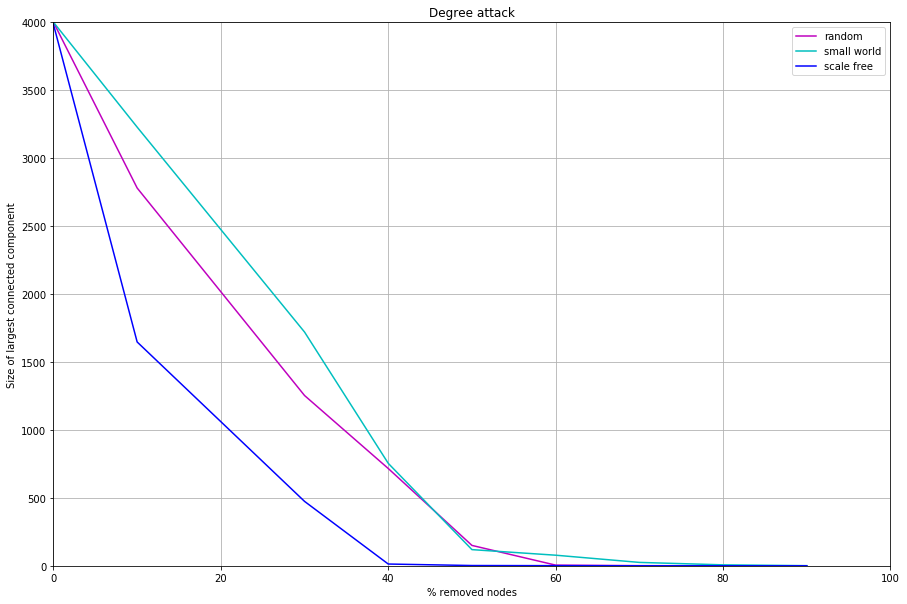

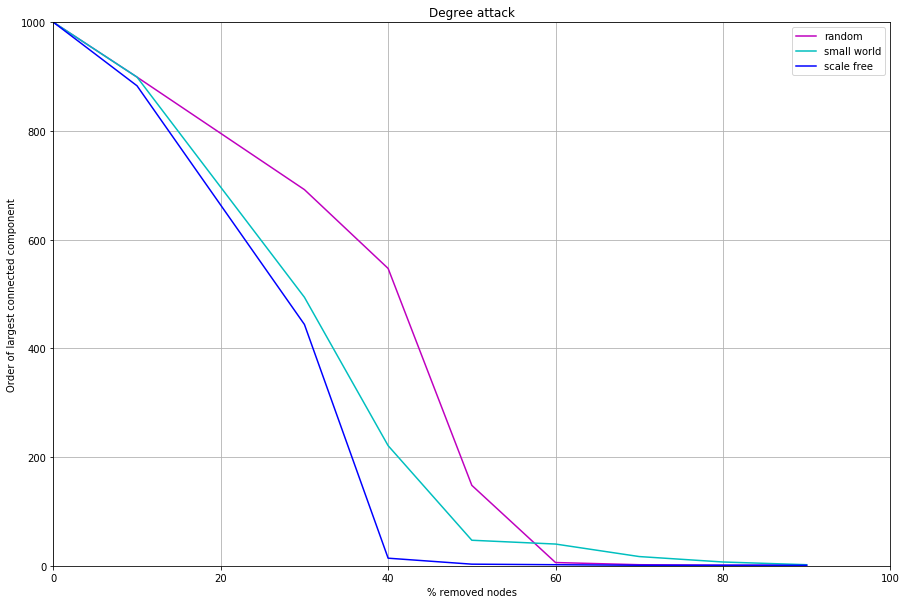

In [151]:
plot_attack(attack_df_degree_sizes, percents_nodes_attacked, "Size", "Degree attack")
plot_attack(attack_df_degree_orders, percents_nodes_attacked, "Order", "Degree attack", 0, 100, 0, 1000)

#### Graphs metrics
We calculate the metrics of all the graphs involved in order to verify that are the type of graphs expected and there are not errors.

In [122]:
# Print the output of function "get_graph_metrics2"
d = {'Random': get_graph_metrics2(graph_random), 
     'Small-World': get_graph_metrics2(graph_small_world),
     'Scale-Free': get_graph_metrics2(graph_scale_free)}
df2 = pd.DataFrame(data=d, index = ['Degree centrality', 'Closeness centrality',
                                  'Betweenness centrality', 'Graph clique number',
                                  'Average clustering', 'Max k-core k',
                                  'Average shortest path length'])
display(df2)

,Random,Small-World,Scale-Free
Degree centrality,0.008008,0.008008,0.007976
Closeness centrality,0.282338,0.123876,0.318568
Betweenness centrality,0.002557,0.007179,0.002166
Graph clique number,3.000000,5.000000,4.000000
Average clustering,0.010371,0.601977,0.037346
Max k-core k,5.000000,6.000000,4.000000
Average shortest path length,3.552160,8.164925,3.161854


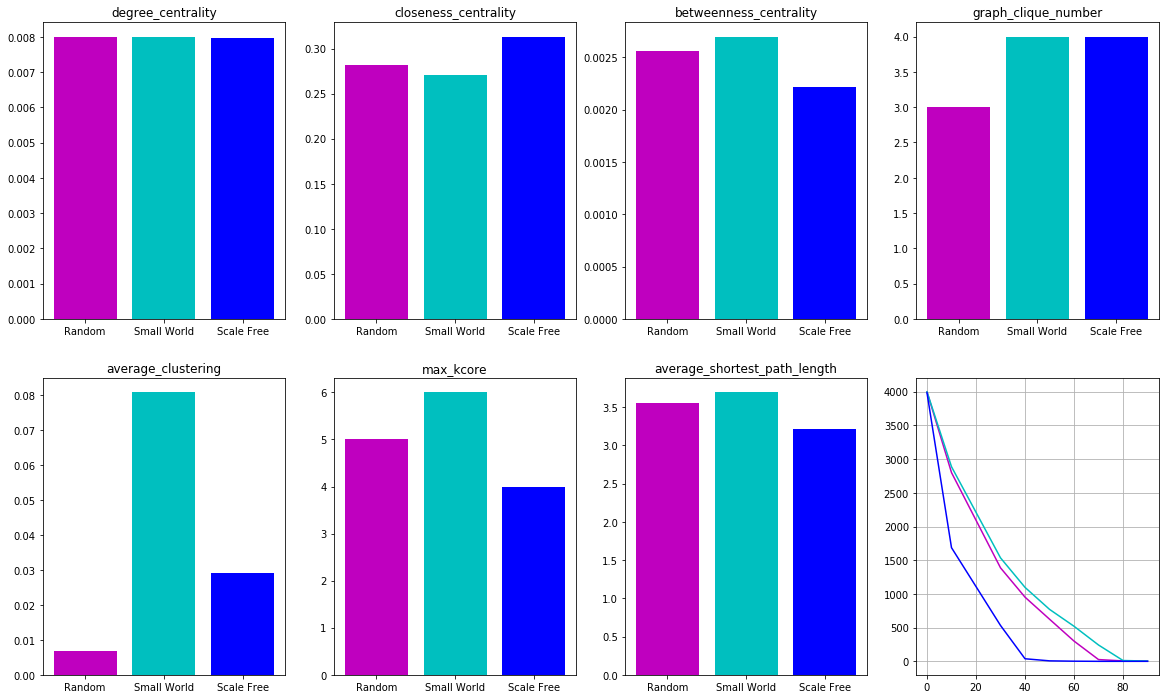

In [207]:
plot_networks(df2, attack_df_degree_sizes, percents_nodes_attacked)

### Comparisons of the previous results

First, in each case we verified that the parameters $C$ and $L$ for are adequate for small-world region of *watts_strogatz_graph*. To do so we print all the metrics of initial graphs attacked.

The order of the connected component with the largest number of nodes is a measure of the network resistance. We compute also the size of this connected component. In the following comments, we focus on the order of the largest connected component.

Bellow we plot the six curves derived from the two attack modes and the three network types.

All results are as theoretical expected.

First, the degree attack is more efficient than the random attack for the three network types, generating a more speedy decreasing of the network resistance. This is due to the nature of the degree attack, with preference by the more connected nodes.

In **degree attack** scale-free has the low resistance, which is dropping more rapidly to zero. This is due to the node degree distribution more biased towards higher degrees than the other. These nodes are more exposed than random or small-world networks, clearly when over 10% of nodes were removed.

The resistance of small-world is dropping with a pattern very similar to scale-free but exhibits clearly more resistance when there are more than 30% of nodes removed. The random network presents more resistance than the other networks, clearly from a removal of 20% nodes.

In **random attack** small world presents the lowest resistance, and scale-free and random have a very similar patterns but the behavior of small-world depends a lot of the probability parameter, the higher this parameter the nearer to the behavior of the other two networks.

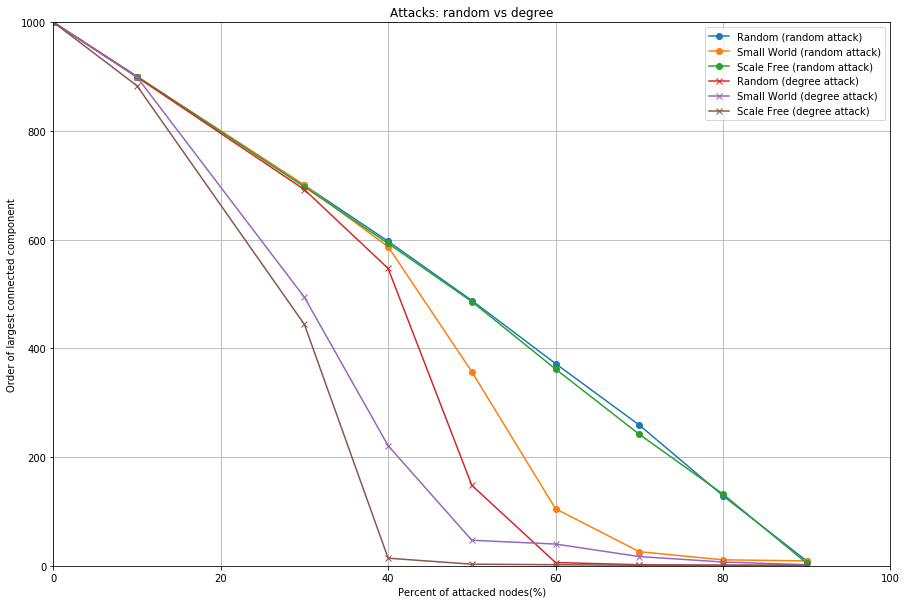

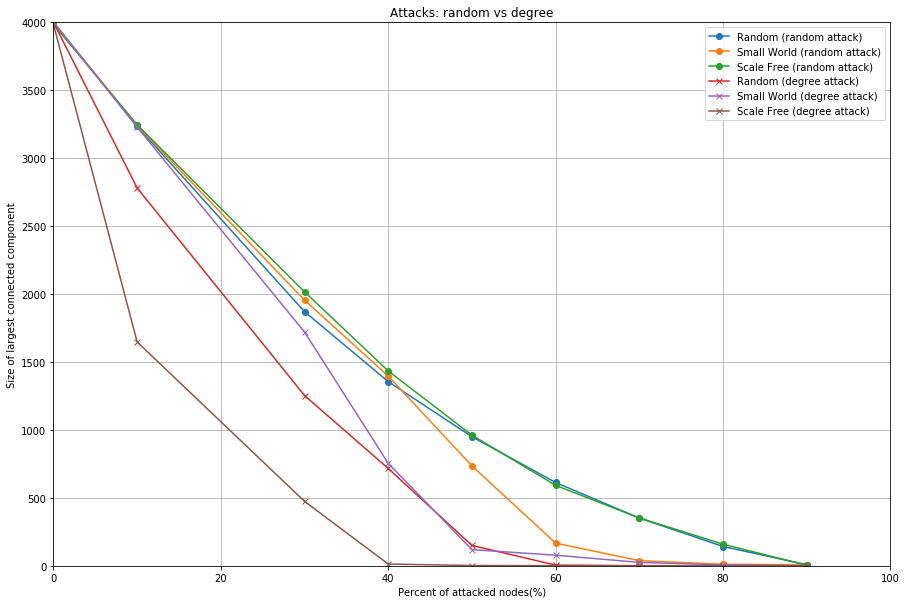

In [138]:
plot_attack_combined(attack_df_random_orders, attack_df_degree_orders, percents_nodes_attacked, 
                     "Order", "Attacks: random vs degree", 0, 100, 0, 1000)
plot_attack_combined(attack_df_random_sizes, attack_df_degree_sizes, percents_nodes_attacked, 
                     "Size", "Attacks: random vs degree")